In [71]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import GradientBoostingClassifier

对球员名字进行处理

In [33]:
seed_athelete = pd.read_excel('.\player_data_ori\seed_athelete.xlsx')
seed_athelete_appendix = pd.read_excel('.\player_data_ori\seed_athelete_appendix.xlsx')
seed_athelete_appendix.loc[seed_athelete_appendix['name'].isnull(),'name'] = seed_athelete_appendix['sub_name']
seed_athelete = seed_athelete.merge(seed_athelete_appendix[['name','team','sub_name','if_multi']],how='left',on=['name','team'])
seed_athelete = seed_athelete.reset_index().rename(columns={'index':'player_id'})
seed_athelete['player_id'] = seed_athelete['player_id'].apply(lambda x: str(x).zfill(3))
seed_athelete.to_parquet('./player_data/athelete_info.parquet')

对球员的转会进行处理

In [34]:
def transfer_data_clean(player_data,name,team):
    #step1:处理球员的transfer_type,包括Permanent_transfer,Free_transfer,Loan_transfer,EndofLoan,Free_agent,EndofFreeagent这几种
    player_data['Transfer_type'] = 'Permanent_transfer'
    player_data['Transfer_type'] = player_data['Fee'].apply(lambda x : 'Loan_transfer' if (('loan' in x)|('Loan' in x)) else 'Permanent_transfer')
    player_data.loc[player_data['Fee'].isin(['freetransfer']),'Transfer_type'] = 'Free_transfer'
    player_data.loc[player_data['Fee'].isin(['Endofloan']),'Transfer_type'] = 'Endofloan'
    player_data.loc[player_data['Left'].isin(['WithoutClub']),'Transfer_type'] = 'EndofFreeagent'
    player_data.loc[player_data['Joined'].isin(['WithoutClub']),'Transfer_type'] = 'Free_agent'
    player_data.drop(player_data.loc[(player_data['Left']!='WithoutClub')&(player_data['Joined']!='WithoutClub')&(player_data['Fee']=='-')].index,inplace = True)
    
    #step2:处理球员的transfer_Fee
    transfer_types = ['Loan_transfer','Free_transfer','Endofloan','EndofFreeagent','Free_agent']
    player_data['multi'] = 1
    player_data.loc[player_data['Transfer_type'].isin(transfer_types),'Fee'] = '0'
    player_data.loc[player_data['Fee']=='?','Fee'] = '-1'
    player_data.loc[player_data['Fee'].str[-1:]=='k','multi'] = 1000
    player_data.loc[player_data['Fee'].str[-1:]=='m','multi'] = 1000000
    player_data['Fee'] = player_data['Fee'].apply(lambda x : float(x.replace('€','').replace('m','').replace('k','')))
    player_data['Fee'] = player_data['Fee']*player_data['multi']
    
    #step3:处理球员的mv(身价)
    player_data['multi'] = 1
    player_data.loc[player_data['MV']=='-','MV'] = '0'
    player_data.loc[player_data['MV'].str[-1:]=='k','multi'] = 1000
    player_data.loc[player_data['MV'].str[-1:]=='m','multi'] = 1000000
    player_data['MV'] = player_data['MV'].apply(lambda x : float(x.replace('€','').replace('m','').replace('k','')))
    player_data['MV'] = player_data['MV']*player_data['multi']
    player_data.drop(columns=['multi'],inplace=True)
    player_data['sub_name'] = name
    player_data['team'] = team
    player_data.reset_index(drop=True)
    player_data = player_data.reset_index().rename(columns={'index':'transfer_id'})
    player_data['transfer_id'] = player_data['transfer_id'].apply(lambda x: str(x).zfill(3))
    return player_data

In [35]:
ori_dir ='./player_data_ori/transfer_data'
seed_athelete = pd.read_parquet('./player_data/athelete_info.parquet')
transfer_data = pd.DataFrame(None,columns=['team','Season','Date','Left','Joined','MV','Fee','Transfer_type'])
for team in os.listdir(ori_dir):
    team_dir = ori_dir+'/'+team
    for file_name in os.listdir(team_dir):
        num,player_name,sub_team = file_name.replace('.csv','').split('_')
        player = pd.read_csv(team_dir+'/'+file_name)
        player = player.rename(columns={'name':'sub_name'})
        player = transfer_data_clean(player,player_name,team)
        transfer_data = pd.concat([transfer_data,player])

transfer_data = transfer_data.merge(seed_athelete[['name','team','sub_name','player_id']],how='left',on=['sub_name','team'])
transfer_data['transfer_id'] = transfer_data['player_id']+transfer_data['transfer_id']
transfer_data = transfer_data[['transfer_id','player_id','name','sub_name','team','Season','Date','Left','Joined','MV','Fee','Transfer_type']]

transfer_data['year'] = transfer_data['Date'].apply(lambda x:int(x[-4:]))
transfer_data['month'] = transfer_data['Date'].apply(lambda x: month_trans[(x[:3])])
transfer_data['transfer_period'] = transfer_data['year']+(transfer_data['month']/13)

transfer_data.to_parquet('./player_data/transfer_data.parquet')

对球员的比赛数据进行处理

In [37]:
def transfer_data_clean(player_data,name,team):
    #step1:处理球员的transfer_type,包括Permanent_transfer,Free_transfer,Loan_transfer,EndofLoan,Free_agent,EndofFreeagent这几种
    player_data['Transfer_type'] = 'Permanent_transfer'
    player_data['Transfer_type'] = player_data['Fee'].apply(lambda x : 'Loan_transfer' if (('loan' in x)|('Loan' in x)) else 'Permanent_transfer')
    player_data.loc[player_data['Fee'].isin(['freetransfer']),'Transfer_type'] = 'Free_transfer'
    player_data.loc[player_data['Fee'].isin(['Endofloan']),'Transfer_type'] = 'Endofloan'
    player_data.loc[player_data['Left'].isin(['WithoutClub']),'Transfer_type'] = 'EndofFreeagent'
    player_data.loc[player_data['Joined'].isin(['WithoutClub']),'Transfer_type'] = 'Free_agent'
    player_data.drop(player_data.loc[(player_data['Left']!='WithoutClub')&(player_data['Joined']!='WithoutClub')&(player_data['Fee']=='-')].index,inplace = True)
    
    #step2:处理球员的transfer_Fee
    transfer_types = ['Loan_transfer','Free_transfer','Endofloan','EndofFreeagent','Free_agent']
    player_data['multi'] = 1
    player_data.loc[player_data['Transfer_type'].isin(transfer_types),'Fee'] = '0'
    player_data.loc[player_data['Fee']=='?','Fee'] = '-1'
    player_data.loc[player_data['Fee'].str[-1:]=='k','multi'] = 1000
    player_data.loc[player_data['Fee'].str[-1:]=='m','multi'] = 1000000
    player_data['Fee'] = player_data['Fee'].apply(lambda x : float(x.replace('€','').replace('m','').replace('k','')))
    player_data['Fee'] = player_data['Fee']*player_data['multi']
    
    #step3:处理球员的mv(身价)
    player_data['multi'] = 1
    player_data.loc[player_data['MV']=='-','MV'] = '0'
    player_data.loc[player_data['MV'].str[-1:]=='k','multi'] = 1000
    player_data.loc[player_data['MV'].str[-1:]=='m','multi'] = 1000000
    player_data['MV'] = player_data['MV'].apply(lambda x : float(x.replace('€','').replace('m','').replace('k','')))
    player_data['MV'] = player_data['MV']*player_data['multi']
    player_data.drop(columns=['multi'],inplace=True)
    player_data['sub_name'] = name
    player_data['team'] = team
    player_data.reset_index(drop=True)
    player_data = player_data.reset_index().rename(columns={'index':'transfer_id'})
    player_data['transfer_id'] = player_data['transfer_id'].apply(lambda x: str(x).zfill(3))
    return player_data

datetime      home_team  away_team score rating                league  \
0   29/05/23      Changchun       Port   0:3    6.4      CFA Super League   
1   02/06/23        Beijing  Changchun   4:3    6.2      CFA Super League   
2   08/06/23      Changchun   Shenzhen   4:1    7.3      CFA Super League   
3   29/06/23       Shandong  Changchun   4:1    6.2      CFA Super League   
4   03/07/23      Changchun      Henan   3:1    6.5      CFA Super League   
..       ...            ...        ...   ...    ...                   ...   
6   10/12/20          Ulsan    Beijing   2:0    NaN  AFC Champions League   
7   18/02/20  Chiangrai Utd    Beijing   0:1    7.2  AFC Champions League   
8   24/04/19        Beijing    Buriram   2:0      -  AFC Champions League   
9   21/05/19     Urawa Reds    Beijing   3:0    6.4  AFC Champions League   
10  09/04/19        Buriram    Beijing   1:3    6.4  AFC Champions League   

                   name             team  
0   Abduhamit Abdugheni  Changchun Yatai  
1   Abduhamit Abdugheni  Changchun Yatai  
2   Abduhamit Abdugheni  Changchun Yatai  
3   Abduhamit Abdugheni  Changchun Yatai  
4   Abduhamit Abdugheni  Changchun Yatai  
..                  ...              ...  
6           Ziming Wang    Beijing Guoan  
7           Ziming Wang    Beijing Guoan  
8           Ziming Wang    Beijing Guoan  
9           Ziming Wang    Beijing Guoan  
10          Ziming Wang    Beijing Guoan  

[31538 rows x 8 columns]

球员身价数据

In [100]:
month_trans = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [101]:
seed_athelete = pd.read_parquet('./player_data/athelete_info.parquet')
player_value = pd.read_excel('./player_data_ori/player_MV.xlsx')
player_value['MV_month'] = player_value['MV_month'].apply(lambda x: month_trans[x])
player_value['birth_month'] = player_value['birth_month'].apply(lambda x: float(month_trans[x]))
player_value['birth'] = player_value['birth_year']+(player_value['birth_month']/13)
player_value['MV_period'] = player_value['MV_year']+(player_value['MV_month']/13)

player_value['multi'] = 1
player_value.loc[player_value['current_mv'].str[-1:]=='k','multi'] = 1000
player_value.loc[player_value['current_mv'].str[-1:]=='m','multi'] = 1000000
player_value['current_mv'] = player_value['current_mv'].apply(lambda x : float(x.replace('€','').replace('m','').replace('k','').replace('-','0')))
player_value['current_mv'] = player_value['current_mv']*player_value['multi']
player_value.drop(columns=['multi'],inplace = True)

player_value = player_value.merge(seed_athelete[['player_id','team','sub_name','name']])
player_value.to_parquet('./player_data/MV_info.parquet')

将球员每年的转会情况进行实例化分析

In [87]:
#确认每个球员从哪一年开始计算，取其有转会记录或者有身价记录的第一年，若是老球员则将范围局限在2013年后
seed_athelete = pd.read_parquet('./player_data/athelete_info.parquet')
transfer_data = pd.read_parquet('./player_data/transfer_data.parquet')
player_value = pd.read_parquet('./player_data/MV_info.parquet')
transfer_data_temp = transfer_data.sort_values(by=['player_id','year','month'],ascending = True)
transfer_data_temp = transfer_data_temp.drop_duplicates(subset=['player_id'],keep='first')[['player_id','year']].rename(columns={'year':'initial_transfer_year'})
player_value_temp = player_value.sort_values(by=['player_id','MV_year','MV_month'],ascending = True)
player_value_temp = player_value_temp.drop_duplicates(subset=['player_id'],keep='first')[['player_id','birth','MV_year']].rename(columns={'MV_year':'initial_MV_year'})
seed_athelete_temp = seed_athelete.merge(transfer_data_temp,how='left').merge(player_value_temp,how='left')
seed_athelete_temp['initial_year'] = seed_athelete_temp['initial_MV_year']
seed_athelete_temp.loc[seed_athelete_temp['initial_year']<2013,'initial_year'] = 2013
seed_athelete_temp.loc[seed_athelete_temp['initial_year'].isnull(),'initial_year'] = seed_athelete_temp['initial_transfer_year']


In [88]:
transfer_instance = pd.DataFrame(None,columns=['player_id','name','position','nationality','height','foot','birth','initial_year'])
for index,row in seed_athelete_temp.iterrows():
    start_year = int(row['initial_year'])
    for i in range(start_year,2024):
        row['initial_year'] = int(i)
        transfer_instance = transfer_instance.append(row)
        
transfer_instance = transfer_instance[['player_id','name','position','nationality','height','foot','birth','initial_year']].rename(columns={'initial_year':'target_year'})

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\423178116.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transfer_instance = transfer_instance.append(row)
C:\U

In [89]:
transfer_data_temp = transfer_data.drop(transfer_data.loc[transfer_data['Transfer_type'].isin(['Free_agent','Endofloan'])].index)
target_transfer_record = pd.DataFrame(None,columns=['player_id','target_year','transfer_period','MV','Fee','Transfer_times','Transfer_type'])
player_list = transfer_data_temp['player_id'].unique()
for player_id in player_list:
    temp1 = transfer_data_temp[transfer_data_temp['player_id']==player_id]
    year_list = temp1['year'].unique()
    for year in year_list:
        temp2 = temp1[temp1['year']==year]
        temp_dic = {'player_id':player_id,'target_year':int(year)}
        temp_dic['transfer_period'] = temp2['transfer_period'].sum()/temp2['transfer_period'].count()
        temp_dic['MV'] = temp2['MV'].sum()/temp2['MV'].count()
        temp_dic['Fee'] = temp2['Fee'].sum()
        temp_dic['Transfer_times'] = temp2['Transfer_type'].count()
        temp_dic['Transfer_type'] = temp2['Transfer_type'].unique()
        target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
target_transfer_record['is_transfer'] = True

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_transfer_record = target_transfer_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\2250882094.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pand

In [90]:
transfer_instance = transfer_instance.merge(target_transfer_record,how='left',on=['player_id','target_year'])
transfer_instance_sub = transfer_instance[transfer_instance['is_transfer'].isnull()]
transfer_instance.drop(transfer_instance.loc[transfer_instance['is_transfer'].isnull()].index,inplace = True)
transfer_instance_sub['is_transfer'] = False

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\3376942778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfer_instance_sub['is_transfer'] = False


In [91]:
target_value_record = pd.DataFrame(None,columns=['player_id','target_year','MV_period','MV'])
player_list = player_value['player_id'].unique()
for player_id in player_list:
    temp1 = player_value[player_value['player_id']==player_id]
    year_list = temp1['MV_year'].unique()
    for year in year_list:
        temp2 = temp1[temp1['MV_year']==year]
        temp_dic = {'player_id':player_id,'target_year':int(year)}
        temp_dic['MV_period'] = temp2['MV_period'].sum()/temp2['MV_period'].count()
        temp_dic['MV'] = temp2['target_mv'].sum()/temp2['target_mv'].count()
        target_value_record = target_value_record.append(temp_dic,ignore_index=True)
transfer_instance_sub.drop(columns=['MV'],inplace = True)
transfer_instance_sub = transfer_instance_sub.merge(target_value_record,how='left',on=['player_id','target_year'])
transfer_instance = pd.concat([transfer_instance,transfer_instance_sub])

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target_value_record = target_value_record.append(temp_dic,ignore_index=True)
C:\Users\hty\AppData\Local\Temp\ipykernel_17756\1225708661.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

In [97]:
def change_height(transfer_instance):
    new_instance = pd.DataFrame(None,columns=['player_id','name','age','position','nationality','height','foot','target_year','MV','is_transfer','Fee','Transfer_times','Transfer_type'])
    for index,row in transfer_instance.iterrows():
        temp_dic = {'player_id':row['player_id'],'name':row['name'],'age':row['age'],'position':row['position'],'nationality':row['nationality'],'height':row['height'],'foot':row['foot'],'target_year':row['target_year'],'MV':row['MV'],'is_transfer':row['is_transfer'],'Fee':row['Fee'],'Transfer_times':row['Transfer_times'],'Transfer_type':row['Transfer_type']}
        height1,height2 = temp_dic['height'].split('′')
        height1 = float(height1.replace(' ',''))
        height2 = float(height2.replace(' ','').replace('″',''))
        height1 = height1*12+height2
        height1 = np.round(height1*2.54)
        temp_dic['height'] = height1
        new_instance = new_instance.append(temp_dic,ignore_index=True)
    return new_instance

In [93]:
transfer_instance = transfer_instance.reset_index(drop=True)
transfer_instance.loc[transfer_instance['MV_period'].isnull(),'age'] = transfer_instance['transfer_period']-transfer_instance['birth']
transfer_instance.loc[transfer_instance['transfer_period'].isnull(),'age'] = transfer_instance['MV_period']-transfer_instance['birth']
transfer_instance.drop(transfer_instance.loc[transfer_instance['age'].isnull()].index,inplace = True)
transfer_instance['age'] = transfer_instance['age'].apply(lambda x: int(x))

transfer_instance = transfer_instance[['player_id','name','age','position','nationality','height','foot','target_year','MV','is_transfer','Fee','Transfer_times','Transfer_type']]
transfer_instance =transfer_instance.sort_values(by=['player_id','target_year'],ascending = True)
transfer_instance = transfer_instance.reset_index(drop=True)
transfer_instance_final = change_height(transfer_instance)
transfer_instance_final.to_parquet('./player_data/transfer_instance.parquet')
transfer_instance_final.to_excel('./player_data/transfer_instance.xlsx',encoding = 'utf-8')

# 新版的球员转会处理

In [12]:
def transfer_data_clean(player_data):
    #step1:处理球员的transfer_type,包括Permanent_transfer,Free_transfer,Loan_transfer,EndofLoan,Free_agent,EndofFreeagent这几种
    player_data['Transfer_type'] = 'Permanent_transfer'
    player_data['Transfer_type'] = player_data['Fee'].apply(lambda x : 'Loan_transfer' if (('loan' in x)|('Loan' in x)) else 'Permanent_transfer')
    player_data.loc[player_data['Fee'].isin(['free transfer']),'Transfer_type'] = 'Free_transfer'
    player_data.loc[player_data['Fee'].isin(['End of loan']),'Transfer_type'] = 'Endofloan'
    player_data.loc[player_data['Left'].isin(['Without Club']),'Transfer_type'] = 'EndofFreeagent'
    player_data.loc[player_data['Joined'].isin(['Without Club']),'Transfer_type'] = 'Free_agent'
    player_data.drop(player_data.loc[(player_data['Left']!='Without Club')&(player_data['Joined']!='Without Club')&(player_data['Fee']=='-')].index,inplace = True)
    
    #step2:处理球员的transfer_Fee
    transfer_types = ['Loan_transfer','Free_transfer','Endofloan','EndofFreeagent','Free_agent']
    player_data['multi'] = 1
    player_data.loc[player_data['Transfer_type'].isin(transfer_types),'Fee'] = '0'
    player_data.loc[player_data['Fee']=='?','Fee'] = '-1'
    player_data.loc[player_data['Fee'].str[-1:]=='k','multi'] = 1000
    player_data.loc[player_data['Fee'].str[-1:]=='m','multi'] = 1000000
    player_data['Fee'] = player_data['Fee'].apply(lambda x : float(x.replace('€','').replace('m','').replace('k','')))
    player_data['Fee'] = player_data['Fee']*player_data['multi']
    
    #step3:处理球员的mv(身价)
    player_data['multi'] = 1
    player_data.loc[player_data['MV']=='-','MV'] = '0'
    player_data.loc[player_data['MV'].str[-1:]=='k','multi'] = 1000
    player_data.loc[player_data['MV'].str[-1:]=='m','multi'] = 1000000
    player_data['MV'] = player_data['MV'].apply(lambda x : float(x.replace('€','').replace('m','').replace('k','')))
    player_data['MV'] = player_data['MV']*player_data['multi']
    player_data.drop(columns=['multi'],inplace=True)
    return player_data

In [35]:
seed_athelete = pd.read_excel('./transfer_data.xlsx')

transfer_data = transfer_data_clean(seed_athelete)

seed_athelete['Year'] = seed_athelete['Date'].str[-4:]
seed_athelete = seed_athelete[seed_athelete['Year']>='2018']
seed_athelete = seed_athelete.drop(seed_athelete.loc[seed_athelete['Transfer_type']=='Endofloan'].index)
seed_athelete.drop(seed_athelete.loc[seed_athelete['Transfer_type']=='EndofFreeagent'].index,inplace = True)

seed_athelete.to_excel('./transfer_data.xlsx')

# 处理一下球员实例

In [46]:
ATT = ['CF','ST','RW','LW']
MID = ['CAM','CDM','CM','RM','LM']
DEF = ['RWB','RB','CB','LB','LWB']
GK = ['GK']

Player_instance = pd.read_csv('./Player_instance.csv')
Player_instance['Year'] = Player_instance['fifa_update_date'].str[0:4]
Player_instance = Player_instance[Player_instance['league_id']==2012]

Player_instance['nation_position'].fillna('No',inplace=True)
Player_instance.loc[Player_instance['nation_position']!='No','nation_position'] = 'Yes'
Player_instance['player_positions'] = Player_instance['player_positions'].apply(lambda x: x.split(',')[0] if ',' in x else x)

Player_instance.loc[Player_instance['detailed_positions'].isin(MID),'total_positions'] = 'MID'
Player_instance.loc[Player_instance['detailed_positions'].isin(ATT),'total_positions'] = 'ATT'
Player_instance.loc[Player_instance['detailed_positions'].isin(DEF),'total_positions'] = 'DEF'
Player_instance.loc[Player_instance['detailed_positions'].isin(GK),'total_positions'] = 'GK'

Team_ranking = pd.read_excel('./Team_ranking.xlsx')
Team_ranking['Year'] = '20'+Team_ranking['Year'].str[-2:]
Team_ranking['Year'] = Team_ranking['Year'].apply(lambda x:int(x))
Player_instance = Player_instance.merge(Team_ranking,how='left',on=['Year','club_team_id'])

transfer_data = pd.read_excel('./transfer_data.xlsx')
Player_instance = Player_instance.merge(transfer_data[['player_id','Year','Transfer_type','Fee']],how='left',on=['player_id','Year'])
Player_instance['Transfer_type'].fillna('No_Transfer',inplace = True)
Player_instance['club_contract_valid_until_year'] = Player_instance['club_contract_valid_until_year'] - Player_instance['Year']
Player_instance.drop(columns=['club_joined_date'],inplace = True)

Player_instance.to_excel('./Player_instance.xlsx',index=False)


# 将所有球员的国内联赛表现记录进行归类

In [85]:
ori_dir = './Game_data/source/'
Performance_data = pd.DataFrame(None)
for names in os.listdir(ori_dir):
    player_id,name = names.split('_')
    try:
        player = pd.read_csv(ori_dir+names+'/table/'+names+'_domestic leagues.csv')
    except FileNotFoundError:
        print(names+' is not found')
        continue
    player['player_id'] = player_id
    player['short_name'] = name
    Performance_data = pd.concat([Performance_data,player],axis = 0)

Performance_data.drop(Performance_data.loc[Performance_data['Competition']=='Play-offs 1/2'].index,inplace = True)
Performance_data.to_excel('./Performance_data.xlsx')

182047_Wu Yan is not found
182464_Zhao Mingjian is not found
224470_He Chao is not found
224645_Sun Jungang is not found
226196_Peng Rui is not found
228072_Qi Tianyu is not found
241251_Lin Longchang is not found
241306_Zhao Keda is not found
241623_Yan Hao is not found
242848_Zheng Zhiming is not found
243072_Ding Bowei is not found
243794_Wei Yu is not found
257708_Ma Defu is not found
257710_Zhang Mengxuan is not found
261924_Yi Wenjun is not found
261977_He Siwei is not found
268969_Li Peinan is not found
269007_Liang Guoqiao is not found


Season                 Team         Competition Appearances Lineups  \
0        2018              Guizhou        Super League           8       8   
1        2017              Guizhou        Super League           5       5   
2        2016                Hebei        Super League          16      11   
3        2013     Shandong Taishan        Super League          21      21   
4        2010             Zhejiang        Super League          16      16   
..        ...                  ...                 ...         ...     ...   
0        2022  Dalian Professional        Super League           -       -   
0        2022  Dalian Professional        Super League           2       -   
1        2021       Shenyang Urban          League One          11       3   
2        2020       Shenyang Urban          League One          13       9   
0   2022/2023   Austria Klagenfurt  Admiral Bundesliga           -       -   

   Substitute In Substitute out Subs on bench Injuries Minutes played  ...  \
0              0              2             3        2            627  ...   
1              0              1             -        -              -  ...   
2              5              1            11        1            847  ...   
3              -              -             2        -              -  ...   
4              -              -             -        -              -  ...   
..           ...            ...           ...      ...            ...  ...   
0              -              -            17        -              -  ...   
0              2              0            13        -             45  ...   
1              8              3             9        -            277  ...   
2              4              5             6        -            691  ...   
0              -              -             1        -              -  ...   

   Red cards Offsides Saves Inside box saves Penalty saved Clean sheets  \
0          -        -     -                -             -            -   
1          -        -     -                -             -            -   
2          -        -     -                -             -            -   
3          -        -     -                -             -            -   
4          -        -     -                -             -            -   
..       ...      ...   ...              ...           ...          ...   
0          -        -     -                -             -            -   
0          -        -     -                -             -            -   
1          -        -     -                -             -            -   
2          -        -     -                -             -            -   
0          -        -     -                -             -            -   

   Conceded Rating player_id   short_name  
0        32   6.33    139927       Du Wei  
1         -      -    139927       Du Wei  
2         -   6.89    139927       Du Wei  
3         -      -    139927       Du Wei  
4         -      -    139927       Du Wei  
..      ...    ...       ...          ...  
0        25      -    269577  Feng Zeyuan  
0        20   6.94    269578     Ning Hao  
1        16      -    269578     Ning Hao  
2        18      -    269578     Ning Hao  
0         2      -    270990       S. Liu  

[4481 rows x 52 columns]

In [110]:
Performance_data = pd.read_excel('./Performance_data.xlsx')
Performance_data.drop(Performance_data.loc[Performance_data['Competition']=='Play-offs 1/2'].index,inplace = True)
Performance_data = Performance_data[Performance_data['Competition']=='Super League']
Performance_data['Season'] = Performance_data['Season'].apply(lambda x: int(x[-4:]) if '/' in str(x) else int(x))
Performance_data = Performance_data[Performance_data['Season']>2017]
new_Performance_data = pd.DataFrame(None)
for player_id in Performance_data['player_id'].unique():
    temp1 = Performance_data[Performance_data['player_id']==player_id]
    for year in temp1['Season'].unique():
        temp2 = temp1[temp1['Season']==year]
        if temp2.shape[0]<=1:
            new_Performance_data = pd.concat([new_Performance_data,temp2])
        else:
            print(player_id)
            columns = ['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']
            temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace = True)
            for column in columns:
                temp2.loc[temp2[column]=='-',column] = 0
                temp2[column] = temp2[column].astype(float)
            temp2['Rating'] = temp2['Rating']*temp2['Appearances']
            temp3 = temp2.groupby(['Season','Competition','player_id','short_name'])[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].sum().reset_index()
            temp3['Rating'] = temp3['Rating']/temp3['Appearances']
            new_Performance_data = pd.concat([new_Performance_data,temp3])
new_Performance_data.to_excel('./Performance_data.xlsx')

181846
182043
182045


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

182094
182094
182343


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

182411
182427
183031


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

186230
191857


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

191861
192598
193713


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

200741
201026
211108


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

216736
217153
217160


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

217160
217160
221798


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

221856


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

222179
222183


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

222197
222273


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

222282
222294
224466
224554
224562


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

224633
224633
224638
224648


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

224731
225739
225739
225991


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

226194
226197


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

227970
227970


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

228035
228077


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

232258
232258
233327


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

233668
233668
233717
233719


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

238104
238105
238109


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

239609
240393


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

240472
241299


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

241302
241312


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

241341
241343
241349


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Rating'] = temp2['Rating']*temp2['Appearances']
C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','

241594
242415


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

243099


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

245036
245039
245040
245040


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

245040
247775
248735
250978


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

250988
251110
251110
253681
253960


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

253963
255632
257690


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

261896
261904


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

261963
263487
264029


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

268966
269008
269009
269011


C:\Users\hty\AppData\Local\Temp\ipykernel_18888\2208059062.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2[['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']].fillna(0,inplace =

269482


In [5]:
Player_instance = pd.read_excel('./Player_instance.xlsx')
Performance_data = pd.read_excel('./Performance_data.xlsx')
Player_instance = Player_instance.merge(Performance_data[['Year','player_id','Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']],how='left',on=['Year','player_id'])
Player_instance.to_excel('./Player_instance.xlsx')


# 对数据作检查和缺失值补充

In [18]:
Player_instance = pd.read_excel('./Player_instance_fin.xlsx')
columns = ['Appearances','Lineups','Substitute In','Substitute out','Subs on bench','Injuries','Minutes played','Goals','Assists','Big Chances Created','Big Chances Missed','Shots','On target','Shots blocked','Hit Woodwork','Passes','Accurate Passes','Key passes','Crosses','Crosses accurate','Long Balls','Through Balls','Passing accuracy','Dribbles attempts','Dribbles success','Dribbled past','Dribbles dispossessed','Duels','Duels won','Tackles','Interceptions','Blocks','Long Balls Won','Aerials Won','Clearances','Fouls committed','Fouls drawn','Yellow cards','2nd Yellow card','Red cards','Offsides','Saves','Inside box saves','Penalty saved','Clean sheets','Conceded','Rating']
Player_instance[columns] = Player_instance[columns].fillna(0)
Player_instance.to_excel('./Player_instance_fin.xlsx')

In [26]:
Player_instance.drop(columns=['id','player_id','Fee'],inplace = True)

Year detailed_positions total_positions  overall  potential  value_eur  \
0     2022                 GK              GK       73         73  1600000.0   
1     2022                 GK              GK       71         71   600000.0   
2     2022                 LB             DEF       71         71   975000.0   
3     2022                 CB             DEF       71         71   900000.0   
4     2022                RWB             DEF       71         71  1400000.0   
...    ...                ...             ...      ...        ...        ...   
1943  2018                 CM             MID       48         66    60000.0   
1944  2018                RWB             DEF       48         58    40000.0   
1945  2018                CDM             MID       48         58    40000.0   
1946  2018                 CM             MID       47         64    60000.0   
1947  2018                 CM             MID       47         61    60000.0   

      wage_eur  age  height_cm  weight_kg  ...  Yellow cards 2nd Yellow card  \
0        12000   31        191         83  ...           0.0             0.0   
1        10000   33        185         75  ...           2.0             0.0   
2         6000   33        185         75  ...           2.0             0.0   
3        11000   33        185         80  ...           4.0             0.0   
4         7000   31        177         75  ...           2.0             0.0   
...        ...  ...        ...        ...  ...           ...             ...   
1943      2000   18        189         75  ...           0.0             0.0   
1944      2000   20        182         70  ...           0.0             0.0   
1945      2000   21        184         72  ...           0.0             0.0   
1946      2000   20        177         79  ...           2.0             0.0   
1947      2000   20        181         64  ...           1.0             0.0   

     Red cards  Offsides  Saves  Inside box saves  Penalty saved  \
0          0.0       0.0   82.0              44.0            0.0   
1          1.0       0.0   43.0              20.0            0.0   
2          0.0       0.0    0.0               0.0            0.0   
3          0.0       0.0    0.0               0.0            0.0   
4          0.0       0.0    0.0               0.0            0.0   
...        ...       ...    ...               ...            ...   
1943       0.0       0.0    0.0               0.0            0.0   
1944       0.0       0.0    0.0               0.0            0.0   
1945       0.0       0.0    0.0               0.0            0.0   
1946       0.0       0.0    0.0               0.0            0.0   
1947       0.0       1.0    0.0               0.0            0.0   

      Clean sheets  Conceded  Rating  
0              0.0      25.0    7.22  
1              0.0      24.0    6.91  
2              0.0       2.0    6.67  
3              0.0      11.0    7.39  
4              0.0      32.0    7.04  
...            ...       ...     ...  
1943           0.0       2.0    0.00  
1944           0.0       9.0    0.00  
1945           0.0       0.0    0.00  
1946           0.0      12.0    6.40  
1947           0.0      33.0    6.73  

[1948 rows x 100 columns]

In [70]:
Player_instance = pd.read_excel('./Player_instance_fin.xlsx')   
Player_instance['PAC'] = (Player_instance['movement_acceleration'] + Player_instance['movement_sprint_speed']) /2
Player_instance['SHO'] = (Player_instance['mentality_positioning'] + Player_instance['attacking_finishing']+ Player_instance['power_long_shots'] + Player_instance['power_shot_power'] + Player_instance['attacking_volleys'] +Player_instance['mentality_penalties'] )/6
Player_instance['PAS'] = (Player_instance['mentality_vision'] + Player_instance['attacking_crossing'] +  +Player_instance['attacking_short_passing'] + Player_instance['skill_long_passing'] + Player_instance['skill_fk_accuracy'] + Player_instance['skill_curve'])/6
Player_instance['DRI'] = (Player_instance['skill_dribbling'] + Player_instance['movement_agility'] + Player_instance['skill_ball_control'] + Player_instance['movement_balance'] + Player_instance['movement_reactions'] + Player_instance['mentality_composure'] )/6
Player_instance['DEF'] = (Player_instance['mentality_interceptions'] + Player_instance['attacking_heading_accuracy'] + Player_instance['defending_marking_awareness'] + Player_instance['defending_standing_tackle'] + Player_instance['defending_sliding_tackle']) /5
Player_instance['PHY'] = (Player_instance['power_jumping'] + Player_instance['power_stamina'] + Player_instance['power_strength'] + Player_instance['mentality_aggression']) /4
Player_instance['Gk'] = (Player_instance['goalkeeping_diving'] + Player_instance['goalkeeping_handling'] + Player_instance['goalkeeping_kicking'] + Player_instance['goalkeeping_positioning'] + Player_instance['goalkeeping_reflexes'])/5
Player_instance.to_excel('./Player_instance_fin2.xlsx') 

# Feature Correlation

In [12]:
Col1 = ['Year','overall','potential','value_eur','wage_eur','age','height_cm','weight_kg','club_contract_valid_until_year','nation_position','release_clause_eur','Team_ranking']
Player_instance = pd.read_excel('./Player_instance_fin2.xlsx')  
Player_instance.loc[Player_instance['nation_position']=='Yes','nation_position'] = 1
Player_instance.loc[Player_instance['nation_position']=='No','nation_position'] = 0

#位置ONE-HOT编码：F，M，D，G
positionDf = pd.DataFrame()
positionDf = pd.get_dummies(Player_instance['total_positions'],prefix='position')
cola = list(positionDf.columns)
Player_instance = pd.concat([Player_instance,positionDf],axis=1)
Player_instance.drop('total_positions',axis=1,inplace=True)

#惯用脚ONE-HOT编码：Left,Right
FootDf = pd.DataFrame()
FootDf = pd.get_dummies(Player_instance['preferred_foot'],prefix='Foot')
colb = list(FootDf.columns)
Player_instance = pd.concat([Player_instance,FootDf],axis=1)
Player_instance.drop('preferred_foot',axis=1,inplace=True)

#转会类型ONE-HOT编码
TransferDf = pd.DataFrame()
TransferDf = pd.get_dummies(Player_instance['Transfer_type'],prefix='Transfer')
colc = list(TransferDf.columns)
Player_instance = pd.concat([Player_instance,TransferDf],axis=1)
Player_instance.drop('Transfer_type',axis=1,inplace=True)

Col1 = Col1+cola+colb+colc
rDf = Player_instance[Col1].corr()
print('相关系数矩阵：')
rDf.to_excel('./fuck.xlsx')

相关系数矩阵：


In [38]:
import pycaret
from pycaret.classification import *
Player_instance = pd.read_excel('./Player_instance_fin3.xlsx')   
#mlflow.set_tracking_uri('./mlflow-server')
#exp1 = setup(Player_instance,target = 'Transfer_type',train_size = 0.8)

In [3]:
#初步的数据集生成
exp1 = setup(Player_instance, target = 'Transfer_type',\
             categorical_features = ['total_positions','nation_position','preferred_foot'],\
             session_id = 123,\
             #keep_features  =['value_eur','wage_eur','release_clause_eur','age','club_contract_valid_until_year'],\
             normalize = True,\
             transformation = True,\
             train_size = 0.8,\
             polynomial_features = True,\
             polynomial_degree = 2,\
             feature_selection = False,\
             fix_imbalance = True,\
             fix_imbalance_method = 'SMOTE',\
            )

In [36]:
get_config('d')

ValueError: Variable 'd' not found. Possible variables are: ['y', 'fix_imbalance', 'train_transformed', 'log_plots_param', 'USI', '_available_plots', 'dataset_transformed', 'is_multiclass', 'html_param', 'logging_param', 'seed', 'fold_groups_param', 'y_transformed', 'data', 'gpu_n_jobs_param', 'n_jobs_param', 'X_test_transformed', 'train', 'idx', 'y_test_transformed', 'X', 'X_transformed', 'dataset', 'exp_name_log', 'pipeline', 'y_train', 'fold_shuffle_param', 'exp_id', 'y_train_transformed', 'X_test', 'X_train_transformed', 'memory', 'y_test', 'test_transformed', 'gpu_param', 'variable_and_property_keys', 'fold_generator', 'variables', 'test', '_ml_usecase', 'target_param', 'X_train']

In [67]:
train_dataset = get_config('train_transformed')
test_dataset = get_config('test_transformed')
total_dataset = pd.concat([train_dataset,test_dataset])
total_dataset.to_csv('./temp_data2.csv')

In [73]:
total_dataset = pd.read_csv('./temp_data2.csv')
Y = total_dataset['Transfer_type']
X = total_dataset.drop(columns = ['Transfer_type'])

In [5]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import GradientBoostingClassifier


Y = total_dataset['Transfer_type']
X = total_dataset.drop(columns = ['Transfer_type'])
model = GradientBoostingClassifier().fit(X ,Y)
selector_gbdt = SelectFromModel(model,threshold = 0.01)
X_selected1 = selector_gbdt.transform(X)
print(1)
LightGBM = lgb.LGBMClassifier().fit(X ,Y)
selector_GBM = SelectFromModel(LightGBM,threshold = 0.9)
X_selected2 = selector_GBM.transform(X)
print(2)
XGB = xgb.XGBClassifier().fit(X ,Y)
selector_XGB = SelectFromModel(XGB,threshold = 0.8)
X_selected3 = selector_XGB.transform(X)
print(3)
CB = cb.CatBoostClassifier().fit(X ,Y)
selector_CB = SelectFromModel(CB,threshold = 0.8)
X_selected4 = selector_CB.transform(X)
print(4)

C:\software\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\software\Anaconda\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.380600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126067
[LightGBM] [Info] Number of data points in the train set: 5225, number of used features: 4607
[LightGBM] [Info] Start training from score -1.427116
[LightGBM] [Info] Start training from score -1.446441
[LightGBM] [Info] Start training from score -1.240022
[LightGBM] [Info] Start training from score -1.447254


C:\software\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


2


C:\software\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\software\Anaconda\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


3
Learning rate set to 0.086089
0:	learn: 1.3148291	total: 4.76s	remaining: 1h 19m 15s
1:	learn: 1.2625611	total: 6.93s	remaining: 57m 40s
2:	learn: 1.2139881	total: 10.4s	remaining: 57m 40s
3:	learn: 1.1723204	total: 12.2s	remaining: 50m 44s
4:	learn: 1.1326756	total: 14s	remaining: 46m 32s
5:	learn: 1.0977796	total: 15.8s	remaining: 43m 45s
6:	learn: 1.0669591	total: 17.6s	remaining: 41m 42s
7:	learn: 1.0363470	total: 19.5s	remaining: 40m 14s
8:	learn: 1.0036955	total: 21.3s	remaining: 39m 4s
9:	learn: 0.9808084	total: 23.1s	remaining: 38m 5s
10:	learn: 0.9562682	total: 24.9s	remaining: 37m 23s
11:	learn: 0.9326951	total: 26.8s	remaining: 36m 47s
12:	learn: 0.9164014	total: 28.6s	remaining: 36m 11s
13:	learn: 0.8957977	total: 30.4s	remaining: 35m 42s
14:	learn: 0.8736438	total: 32.3s	remaining: 35m 18s
15:	learn: 0.8584843	total: 34.1s	remaining: 34m 56s
16:	learn: 0.8390148	total: 35.9s	remaining: 34m 37s
17:	learn: 0.8219304	total: 37.7s	remaining: 34m 17s
18:	learn: 0.8086460	tota

153:	learn: 0.2894216	total: 4m 54s	remaining: 26m 56s
154:	learn: 0.2884637	total: 4m 56s	remaining: 26m 54s
155:	learn: 0.2877922	total: 4m 57s	remaining: 26m 51s
156:	learn: 0.2860100	total: 4m 59s	remaining: 26m 49s
157:	learn: 0.2850773	total: 5m 1s	remaining: 26m 47s
158:	learn: 0.2833647	total: 5m 3s	remaining: 26m 45s
159:	learn: 0.2822903	total: 5m 5s	remaining: 26m 42s
160:	learn: 0.2801137	total: 5m 7s	remaining: 26m 40s
161:	learn: 0.2779591	total: 5m 8s	remaining: 26m 38s
162:	learn: 0.2771832	total: 5m 10s	remaining: 26m 35s
163:	learn: 0.2758550	total: 5m 12s	remaining: 26m 33s
164:	learn: 0.2744662	total: 5m 14s	remaining: 26m 31s
165:	learn: 0.2728689	total: 5m 16s	remaining: 26m 28s
166:	learn: 0.2718930	total: 5m 17s	remaining: 26m 26s
167:	learn: 0.2708676	total: 5m 19s	remaining: 26m 24s
168:	learn: 0.2695634	total: 5m 21s	remaining: 26m 21s
169:	learn: 0.2683124	total: 5m 23s	remaining: 26m 19s
170:	learn: 0.2678365	total: 5m 25s	remaining: 26m 17s
171:	learn: 0.2

303:	learn: 0.1864557	total: 9m 24s	remaining: 21m 32s
304:	learn: 0.1860468	total: 9m 26s	remaining: 21m 31s
305:	learn: 0.1857036	total: 9m 28s	remaining: 21m 28s
306:	learn: 0.1854385	total: 9m 30s	remaining: 21m 26s
307:	learn: 0.1852237	total: 9m 31s	remaining: 21m 24s
308:	learn: 0.1843802	total: 9m 33s	remaining: 21m 22s
309:	learn: 0.1840671	total: 9m 35s	remaining: 21m 20s
310:	learn: 0.1838624	total: 9m 37s	remaining: 21m 18s
311:	learn: 0.1835613	total: 9m 39s	remaining: 21m 16s
312:	learn: 0.1831727	total: 9m 40s	remaining: 21m 14s
313:	learn: 0.1829280	total: 9m 42s	remaining: 21m 12s
314:	learn: 0.1827828	total: 9m 44s	remaining: 21m 10s
315:	learn: 0.1825710	total: 9m 46s	remaining: 21m 8s
316:	learn: 0.1824867	total: 9m 47s	remaining: 21m 6s
317:	learn: 0.1821914	total: 9m 49s	remaining: 21m 4s
318:	learn: 0.1814858	total: 9m 51s	remaining: 21m 2s
319:	learn: 0.1809662	total: 9m 53s	remaining: 21m
320:	learn: 0.1807106	total: 9m 55s	remaining: 20m 58s
321:	learn: 0.1802

451:	learn: 0.1405899	total: 13m 48s	remaining: 16m 44s
452:	learn: 0.1401994	total: 13m 50s	remaining: 16m 42s
453:	learn: 0.1400146	total: 13m 51s	remaining: 16m 40s
454:	learn: 0.1396866	total: 13m 53s	remaining: 16m 38s
455:	learn: 0.1394061	total: 13m 55s	remaining: 16m 36s
456:	learn: 0.1391925	total: 13m 57s	remaining: 16m 34s
457:	learn: 0.1390015	total: 13m 58s	remaining: 16m 32s
458:	learn: 0.1386920	total: 14m	remaining: 16m 30s
459:	learn: 0.1383897	total: 14m 2s	remaining: 16m 28s
460:	learn: 0.1381574	total: 14m 4s	remaining: 16m 27s
461:	learn: 0.1380036	total: 14m 6s	remaining: 16m 25s
462:	learn: 0.1377203	total: 14m 7s	remaining: 16m 23s
463:	learn: 0.1371489	total: 14m 9s	remaining: 16m 21s
464:	learn: 0.1370051	total: 14m 11s	remaining: 16m 19s
465:	learn: 0.1368598	total: 14m 13s	remaining: 16m 17s
466:	learn: 0.1366753	total: 14m 14s	remaining: 16m 15s
467:	learn: 0.1364108	total: 14m 16s	remaining: 16m 13s
468:	learn: 0.1361269	total: 14m 18s	remaining: 16m 11s
4

599:	learn: 0.1113574	total: 18m 11s	remaining: 12m 7s
600:	learn: 0.1111376	total: 18m 13s	remaining: 12m 6s
601:	learn: 0.1110250	total: 18m 15s	remaining: 12m 4s
602:	learn: 0.1109415	total: 18m 17s	remaining: 12m 2s
603:	learn: 0.1108084	total: 18m 18s	remaining: 12m
604:	learn: 0.1107265	total: 18m 20s	remaining: 11m 58s
605:	learn: 0.1106675	total: 18m 22s	remaining: 11m 56s
606:	learn: 0.1105639	total: 18m 24s	remaining: 11m 54s
607:	learn: 0.1103272	total: 18m 26s	remaining: 11m 53s
608:	learn: 0.1101909	total: 18m 27s	remaining: 11m 51s
609:	learn: 0.1099434	total: 18m 29s	remaining: 11m 49s
610:	learn: 0.1096692	total: 18m 31s	remaining: 11m 47s
611:	learn: 0.1094480	total: 18m 33s	remaining: 11m 45s
612:	learn: 0.1094002	total: 18m 34s	remaining: 11m 43s
613:	learn: 0.1091194	total: 18m 36s	remaining: 11m 42s
614:	learn: 0.1090742	total: 18m 38s	remaining: 11m 40s
615:	learn: 0.1089559	total: 18m 40s	remaining: 11m 38s
616:	learn: 0.1087959	total: 18m 42s	remaining: 11m 36s


748:	learn: 0.0915139	total: 22m 37s	remaining: 7m 34s
749:	learn: 0.0913685	total: 22m 38s	remaining: 7m 32s
750:	learn: 0.0913025	total: 22m 40s	remaining: 7m 31s
751:	learn: 0.0911304	total: 22m 42s	remaining: 7m 29s
752:	learn: 0.0910403	total: 22m 44s	remaining: 7m 27s
753:	learn: 0.0909245	total: 22m 45s	remaining: 7m 25s
754:	learn: 0.0908424	total: 22m 47s	remaining: 7m 23s
755:	learn: 0.0906966	total: 22m 49s	remaining: 7m 22s
756:	learn: 0.0905565	total: 22m 51s	remaining: 7m 20s
757:	learn: 0.0904816	total: 22m 53s	remaining: 7m 18s
758:	learn: 0.0903395	total: 22m 54s	remaining: 7m 16s
759:	learn: 0.0902437	total: 22m 56s	remaining: 7m 14s
760:	learn: 0.0901590	total: 22m 58s	remaining: 7m 12s
761:	learn: 0.0899810	total: 23m	remaining: 7m 11s
762:	learn: 0.0897250	total: 23m 1s	remaining: 7m 9s
763:	learn: 0.0895214	total: 23m 3s	remaining: 7m 7s
764:	learn: 0.0894624	total: 23m 5s	remaining: 7m 5s
765:	learn: 0.0893170	total: 23m 7s	remaining: 7m 3s
766:	learn: 0.0891905	

899:	learn: 0.0767996	total: 27m 5s	remaining: 3m
900:	learn: 0.0767337	total: 27m 7s	remaining: 2m 58s
901:	learn: 0.0765637	total: 27m 9s	remaining: 2m 56s
902:	learn: 0.0764968	total: 27m 10s	remaining: 2m 55s
903:	learn: 0.0763754	total: 27m 12s	remaining: 2m 53s
904:	learn: 0.0763201	total: 27m 14s	remaining: 2m 51s
905:	learn: 0.0762083	total: 27m 16s	remaining: 2m 49s
906:	learn: 0.0761554	total: 27m 17s	remaining: 2m 47s
907:	learn: 0.0760557	total: 27m 19s	remaining: 2m 46s
908:	learn: 0.0759930	total: 27m 21s	remaining: 2m 44s
909:	learn: 0.0759165	total: 27m 23s	remaining: 2m 42s
910:	learn: 0.0758122	total: 27m 25s	remaining: 2m 40s
911:	learn: 0.0757396	total: 27m 26s	remaining: 2m 38s
912:	learn: 0.0757115	total: 27m 28s	remaining: 2m 37s
913:	learn: 0.0755812	total: 27m 30s	remaining: 2m 35s
914:	learn: 0.0755116	total: 27m 32s	remaining: 2m 33s
915:	learn: 0.0754235	total: 27m 34s	remaining: 2m 31s
916:	learn: 0.0752760	total: 27m 35s	remaining: 2m 29s
917:	learn: 0.075

C:\software\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


4


In [92]:
LightGBM = lgb.LGBMClassifier().fit(X ,Y)
selector_GBM = SelectFromModel(LightGBM,threshold = 100)
X_selected6 = selector_GBM.transform(X)
feature_idx1 = selector_GBM.get_support()
feature_name1 = X.columns[feature_idx1]
X1 = pd.DataFrame(X_selected6 ,columns=feature_name1)
X1 = pd.concat([X1,Y],axis=1)
X1.to_csv('./GBM.csv',index = False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23834
[LightGBM] [Info] Number of data points in the train set: 5225, number of used features: 95
[LightGBM] [Info] Start training from score -1.427116
[LightGBM] [Info] Start training from score -1.446441
[LightGBM] [Info] Start training from score -1.240022
[LightGBM] [Info] Start training from score -1.447254


In [93]:
print(X_selected6.shape)

(5225, 53)
(5225, 93)


In [110]:
Y = total_dataset['Transfer_type']
X = total_dataset.drop(columns = ['Transfer_type'])
model = GradientBoostingClassifier().fit(X ,Y)
selector_gbdt = SelectFromModel(model,threshold = 0.005)
X_selected1 = selector_gbdt.transform(X)
print(X_selected1.shape)



(5225, 33)


In [109]:
XGB = xgb.XGBClassifier().fit(X ,Y)
selector_XGB = SelectFromModel(XGB,threshold = 0.005)
X_selected3 = selector_XGB.transform(X)
print(X_selected3.shape)

(5225, 54)


In [111]:
#selected1 选择
feature_idx1 = selector_gbdt.get_support()
feature_name1 = X.columns[feature_idx1]
X1 = pd.DataFrame(X_selected1 ,columns=feature_name1)
X1 = pd.concat([X1,Y],axis=1)
X1.to_csv('./GDBT.csv')

feature_idx1 = selector_XGB.get_support()
feature_name1 = X.columns[feature_idx1]
X1 = pd.DataFrame(X_selected3 ,columns=feature_name1)
X1 = pd.concat([X1,Y],axis=1)
X1.to_csv('./XGB.csv')

feature_idx1 = selector_GBM.get_support()
feature_name1 = X.columns[feature_idx1]
X1 = pd.DataFrame(X_selected6 ,columns=feature_name1)
X1 = pd.concat([X1,Y],axis=1)
X1.to_csv('./GBM1.csv')

feature_idx1 = selector_GBM2.get_support()
feature_name1 = X.columns[feature_idx1]
X1 = pd.DataFrame(X_selected5 ,columns=feature_name1)
X1 = pd.concat([X1,Y],axis=1)
X1.to_csv('./GBM2.csv')

In [120]:
import pycaret
from pycaret.classification import *
Player_instance = pd.read_csv('./GBM.csv')  


exp1 = setup(Player_instance, target = 'Transfer_type',\
             session_id = 123,\
             normalize = False,\
             normalize_method = 'minmax',\
             transformation = False,\
             train_size = 0.8,\
             polynomial_features = False,\
             feature_selection = False,\
             fix_imbalance = False,\
             fix_imbalance_method = 'SMOTE',\
            )

In [121]:
X_train = get_config('X_transformed')

In [122]:
predict = get_config('test_transformed')
predict = predict.reset_index(drop = True)

In [123]:
x_predict = predict.drop(columns=['Transfer_type'])
y_predict = predict['Transfer_type']

In [117]:
a = compare_models()

In [29]:
print(a)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=2831, verbose=0,
                       warm_start=False)


In [101]:
xgboost = create_model('xgboost')

In [102]:
tuned_xgboost = tune_model(xgboost)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [8]:
gbc_bagged = ensemble_model(tuned_gbc)

In [125]:
et = create_model('et')

In [124]:
tuned_et = tune_model(et)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [11]:
et_bagged = ensemble_model(tuned_et)

In [24]:
lightgbm_holdout_pred = predict_model(lightgbm_bagged)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 

In [6]:
rf = create_model('rf')

In [13]:
tuned_rf = tune_model(rf)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [14]:
rf_bagged = ensemble_model(tuned_rf)

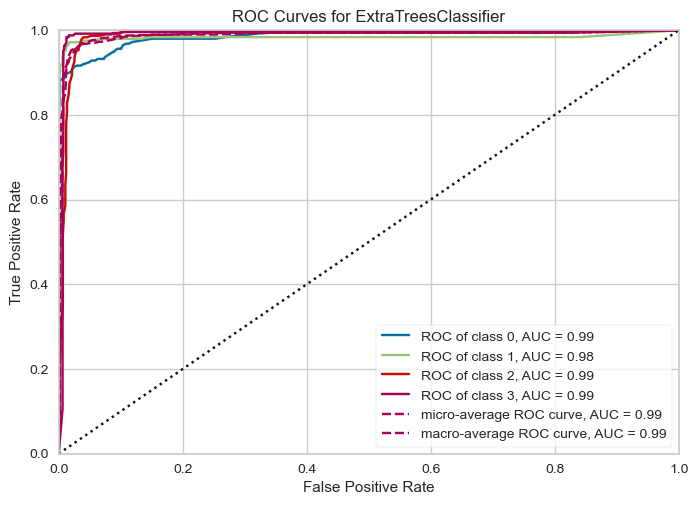

In [104]:
plot_model(et)

In [98]:
lightgbm = create_model('lightgbm')

In [99]:
tuned_gbm = tune_model(lightgbm)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [126]:
lightgbm_holdout_pred = predict_model(et)

In [127]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

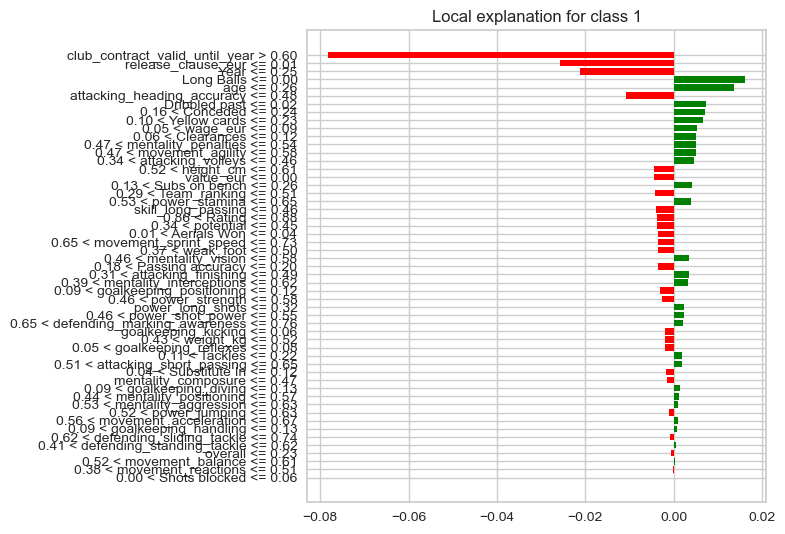

In [131]:
# 导入所需的库
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

feature_names = X_train.columns.tolist()
# 创建LIME解释器
explainer = LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=[0,1,2,3])

# 选择要解释的实例
instance_idx = 0
instance = x_predict.iloc[instance_idx]
true_class = y_predict[instance_idx]

# 使用LIME解释模型预测结果
exp = explainer.explain_instance(instance, et.predict_proba, num_features=len(feature_names))

# 打印解释结果
exp.show_in_notebook(show_table=True, show_all=True)
# 显示权重图
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


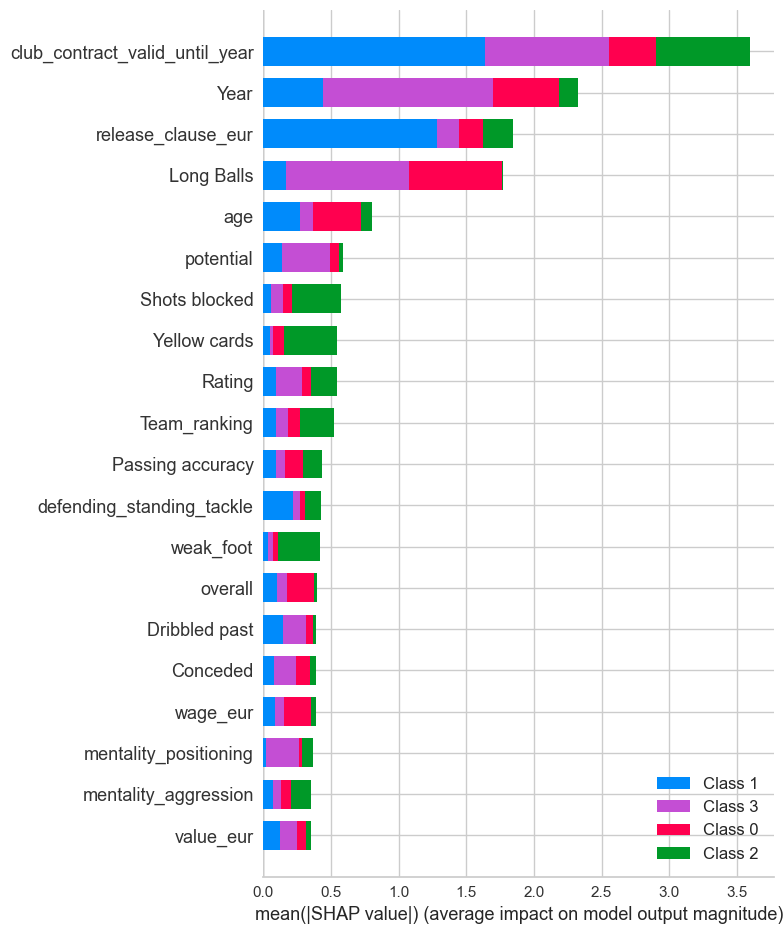

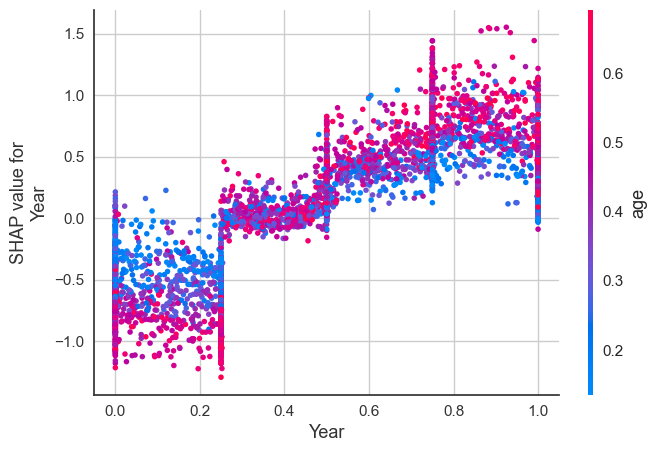

In [132]:
import shap
explainer = shap.TreeExplainer(lightgbm)

# 计算 SHAP 值
shap_values = explainer.shap_values(X_train)

shap.initjs()
# 生成 SHAP 值汇总图
shap.summary_plot(shap_values, X_train)

# 生成单个特征的依赖图
shap.dependence_plot('Year', shap_values[0], X_train)

#绘制力图
#shap.force_plot(explainer.expected_value, shap_values, X_train)

#绘制决策图
#shap.decision_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [59]:
X_train

Year  club_contract_valid_until_year  release_clause_eur  \
3646  2.220000e-16                       -1.284002            0.561751   
1643 -8.330000e-16                       -0.426229           -0.477610   
5083  1.050000e-15                       -1.284002            1.319553   
930  -1.050000e-15                       -1.284002            0.561751   
1218  2.110000e-15                        1.712420           -0.409175   
...            ...                             ...                 ...   
2980  2.220000e-16                       -0.111885           -0.246182   
1782  2.110000e-15                       -1.043074           -0.855729   
1870  1.280000e-15                       -0.615858            0.983293   
4869 -2.160000e-15                       -0.241418            0.830589   
4079 -2.160000e-15                        0.944497            1.450235   

        Year^2  overall preferred_foot  potential height_cm  \
3646  0.137590               -0.467288             0.732179   
1643 -0.585083               -0.352356            -0.474459   
5083  0.731046                1.134380             0.764248   
930  -0.748115                0.979396             1.561234   
1218  1.468517                0.315715            -0.322441   
...        ...                     ...                  ...   
2980  0.156412                0.418397             0.174971   
1782  1.468517               -2.172812            -0.549211   
1870  0.872530                0.949988             0.554098   
4869 -1.489675                0.677517             0.783252   
4079 -1.489675               -1.811301             0.377292   

      potential weight_kg  club_contract_valid_until_year^2  \
3646             0.532822                         -1.236923   
1643            -0.481817                         -0.660766   
5083             0.848989                         -1.236923   
930              1.828193                         -1.236923   
1218             0.252714                          1.704381   
...                   ...                               ...   
2980             0.491964                          0.213742   
1782            -0.252238                         -0.921669   
1870             0.758071                         -0.251339   
4869             0.446104                         -0.547420   
4079             0.305586                          0.917448   

      club_contract_valid_until_year preferred_foot  \
3646                                      -1.128554   
1643                                      -0.086262   
5083                                      -1.128554   
930                                       -1.128554   
1218                                       1.663941   
...                                             ...   
2980                                       0.235458   
1782                                      -0.808223   
1870                                      -0.294540   
4869                                       0.106268   
4079                                      -0.069331   

      club_contract_valid_until_year skill_moves  \
3646                                   -1.302389   
1643                                   -0.352675   
5083                                   -1.302389   
930                                    -1.302389   
1218                                    1.518001   
...                                          ...   
2980                                   -0.052431   
1782                                   -1.006223   
1870                                   -0.542457   
4869                                   -0.174296   
4079                                    1.378555   

      club_contract_valid_until_year Team_ranking  \
3646                                    -1.303391   
1643                                    -0.328516   
5083                                    -1.303391   
930                                     -1.303391   
1218                                     1.623747   
...    

In [58]:
shap_values

[array([[-1.36543325e-04, -2.74025100e-02, -1.02240824e-01, ...,
         -6.53011732e-02,  3.29883105e-02, -1.75721132e-02],
        [-7.05345699e-02,  1.76355938e-02,  1.69022644e-01, ...,
          3.09952893e-03,  4.93796187e-02,  1.51067450e-02],
        [ 1.01611137e-01,  7.45848516e-02, -2.98357149e-01, ...,
          2.88671246e-01,  5.30203091e-01,  1.47999559e-01],
        ...,
        [ 2.09573605e-01,  9.67526469e-02,  5.68668271e-02, ...,
          3.60264268e-02,  2.94735547e-01,  1.95019265e-01],
        [-9.31324405e-02, -7.55166470e-02,  4.88564305e-02, ...,
          1.48150720e-01, -6.58232659e-04,  7.84945108e-02],
        [-1.57007162e-01, -6.61228830e-02, -5.96298176e-01, ...,
          1.06043251e-02, -1.88562486e-01,  3.81120557e-02]]),
 array([[ 0.01486885,  0.49091386,  1.72421022, ...,  0.85538481,
          0.33104382,  0.16896765],
        [ 0.12742206,  0.24070521, -1.64243351, ..., -0.12465154,
          0.1312791 ,  0.08616528],
        [-0.04556823,  0.

In [15]:
feature_select_lime_plot(X_train,lightgbm,predict[1])

KeyError: 1

In [8]:
lightgbm = load_model('myass', platform = None, authentication = None, verbose=True)

Transformation Pipeline and Model Successfully Loaded


In [11]:
save_experiment(experiment_name='fuckingass',path_or_file = 'file')

TypeError: dump() got an unexpected keyword argument 'experiment_name'